In [ ]:
IN_COLAB = 'google.colab' in str(get_ipython())
if IN_COLAB:
	!pip install seaborn
	!pip install statsmodels
	!pip install pycaret
	!pip install pyod

# Note pycaret and pmdarima libraries are incompatible for version 2021/12/24

# Visualization of Anomaly Detection Methods

1. 2d Plots
2. T-distributed Stochastic Neighbor Embedding Plot

In [1]:
%matplotlib inline

import pandas as pd
from data.jpx import *
from utils.outlier import *
from pycaret.anomaly import *
import random
from sklearn import metrics
TSE33 = TOPIX_SECTORS()
NKY = Nikkei225() 
try:
	s
except NameError:
	inst = NKY.get_ric("6758.T")  # Small cap 1332, 3103, 5707, 6703,    Large cap 6758, 7203, 6098 9432
	print(f"inst: {inst}")
	s = Stock(inst, TSE33)
else:
    print(s.df_intraday.drop(columns=["COUNT", "VOLUME", "DATE", "TIME", "CLOSE_TPX", "RETURN_ADJ_TPX", "RETURN_NORM_TPX"]).head())

inst: [132 '6758.T' 'Sony Group Corp' 'Electric Appliances']


### Set Global Anomaly at point 100

The outlier type is "Global"  `outlier_type = "Global"`

Percent of data to mark as outliers is 2%  `outliers_fraction = 0.02`

Data is for 2020-11-24 `s.unique_dates[0]`

Time is 01:44:00 GMT or 10:44 JST `anomaly=100`

In [10]:
# Import PyOD models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.pca import PCA
from pyod.models.ocsvm import OCSVM
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.deep_svdd import DeepSVDD

field = "RETURN_NORM"
df = s.window(s.unique_dates[0], wdw_len=0)
outliers_fraction = 0.02
outlier_type = "Global" # ["Global", "Contextual", "Collective", "All Three"]
data, anomaly = injectOutlier(df, field, outlier_type, anomaly=100)
random_state = np.random.RandomState(42)

pyod_classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Local Outlier Factor (LOF)':LOF(n_neighbors=35, contamination=outliers_fraction),
        'Principal Component Analysis (PCA)': PCA(contamination=outliers_fraction),
        'One-Class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
        'AutoEncoder (AE)': AutoEncoder(hidden_neurons=[25, 2, 2, 25], epochs=30, verbose=0, contamination=outliers_fraction),
        'DeepSVDD (DeepSVDD)': AutoEncoder(hidden_neurons=[25, 2, 2, 25], epochs=30, verbose=0, contamination=outliers_fraction)   
}

μ: 0.45785690825890163   σ: 0.1372199522854169    MAD: 0.0782037012223476   first: 100


## 1. 2D Plots
Plots of all the different anomaly detection methods for a Global Outlier in Sony Data at 10:44 JST (100).

OUTLIERS :  6 INLIERS :  290 Angle-based Outlier Detector (ABOD)


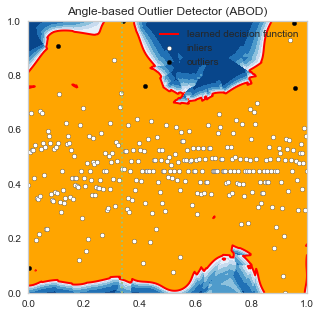

OUTLIERS :  6 INLIERS :  290 Cluster-based Local Outlier Factor (CBLOF)


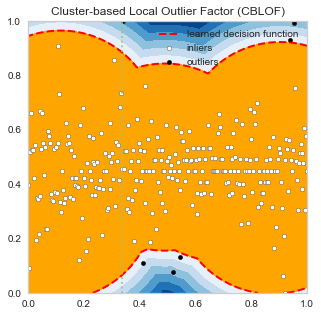

OUTLIERS :  6 INLIERS :  290 Histogram-base Outlier Detection (HBOS)


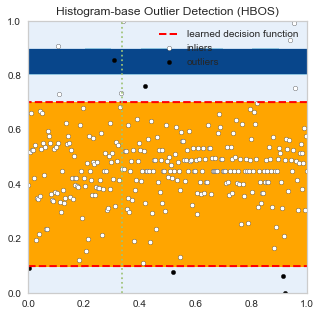

OUTLIERS :  6 INLIERS :  290 Isolation Forest


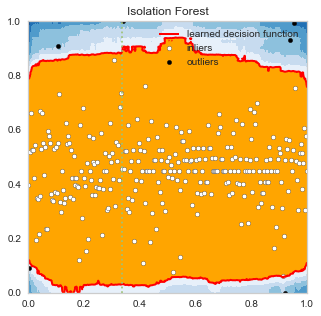

OUTLIERS :  5 INLIERS :  291 K Nearest Neighbors (KNN)


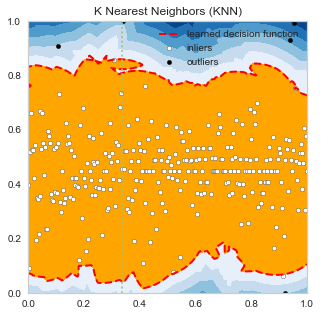

OUTLIERS :  5 INLIERS :  291 Local Outlier Factor (LOF)


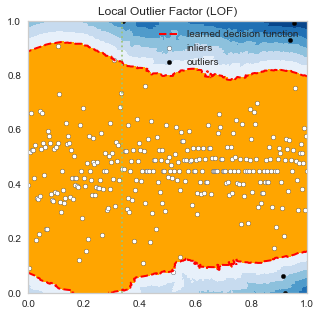

OUTLIERS :  6 INLIERS :  290 Principal Component Analysis (PCA)


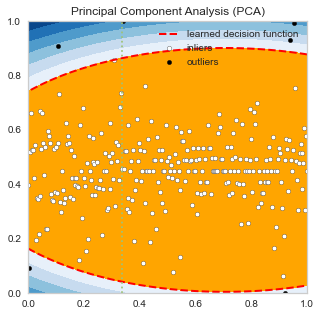

OUTLIERS :  6 INLIERS :  290 One-Class SVM (OCSVM)


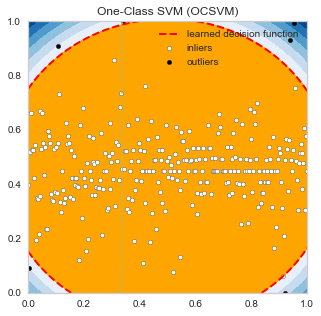

OUTLIERS :  6 INLIERS :  290 AutoEncoder (AE)


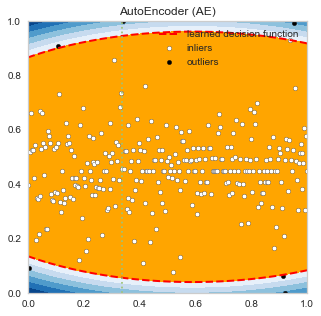

OUTLIERS :  6 INLIERS :  290 DeepSVDD (DeepSVDD)


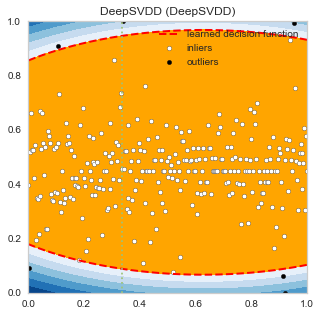

In [4]:

# Code modified from https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/

xx , yy = np.meshgrid(np.linspace(0,1 , 296), np.linspace(0, 1, 296))

scaler = MinMaxScaler(feature_range=(0, 1))

data1 = data[[field]].reset_index()
data1[['index',field]] = scaler.fit_transform(data1[['index',field]])

X1 = data1['index'].values.reshape(-1,1)
X2 = data1[field].values.reshape(-1,1)
X = np.concatenate((X1,X2),axis=1)
# print(X[:5])
# print(pred.head())

for i, (clf_name, clf) in enumerate(pyod_classifiers.items()):

    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(5, 5))
    
    # copy of dataframe
    dfx = data1
    dfx['outlier'] = y_pred.tolist()
    # print(dfx.head())
    
    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    IX1 =  np.array(dfx['index'][dfx['outlier'] == 0]).reshape(-1,1)
    IX2 =  np.array(dfx['RETURN_NORM'][dfx['outlier'] == 0]).reshape(-1,1)
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 =  dfx['index'][dfx['outlier'] == 1].values.reshape(-1,1)
    OX2 =  dfx['RETURN_NORM'][dfx['outlier'] == 1].values.reshape(-1,1)
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
          
    # fill colors
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
        
    b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
    c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
    plt.axvline(x=(anomaly/len(df)), ls=':', c='g')   
    plt.axis('tight')  
    
    # loc is the position of the legend
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'],
        loc=1)
      
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    # plt.savefig(f'chart{i}.png')
    plt.show()


## 2. T-distributed Stochastic Neighbor Embedding Plot
t-SNE is a method to visualize high-dimensional data. A t-distributed stochastic neighbor embedding plot converts similarities between data points to joint probabilities. It minimizes the Kullback-Leibler divergence between the joint probabilities of the low-dimensional subspace and the high-dimensional original data. 

In [8]:

model_name = 'lof' # ['abod', 'cluster', 'histogram', 'iforest', 'knn', 'lof', 'pca', 'svm', 'AutoEncoder (AE)', 'DeepSVDD (DeepSVDD)']
outlier_type = "Contextual" # ["Global", "Contextual", "Collective"]
data, anomaly = injectOutlier(df, field, outlier_type, anomaly=100)
pycaret_setup = setup(data, session_id = 100, silent=True)
model = create_model(model_name, fraction=outliers_fraction)
plot_model(model, plot = 'tsne')
print(f"The anomaly is at {anomaly}.")
print(data[95:105])


The anomaly is at 100.
     index  RETURN_NORM  RETURN_NORM_tpx      time
95      95     0.547998         0.703597  0.322034
96      96     0.416648         0.705194  0.325424
97      97     0.686522         0.498247  0.328814
98      98     0.741424         0.499454  0.332203
99      99     0.459617         0.603910  0.335593
100    100     0.554477         0.990954  0.338983
101    101     0.459617         0.549354  0.342373
102    102     0.525218         0.574986  0.345763
103    103     0.524839         0.665212  0.349153
104    104     0.310829         0.562778  0.352542
